# 第2单元：音频应用概览

欢迎来到Hugging Face音频课程的第二单元！我们已经掌握了音频数据的基础，以及使用🤗 Datasets和 🤗 Transformers加载音频数据的方法。我们已经了解了许多音频相关的概念，例如采样率、位深度、波形、时频谱等等。我们也已经了解到如何对数据进行预处理，并为模型的预训练准备数据。

现在，你也许会想了解🤗 Transformers能处理怎样的任务，并且你已经掌握了所有相关的基础知识！我们来看看这些令人震惊的音频应用吧：

声音分类（Audio classification）：将音频片段分入不同的类别。我们可以认出该音频是汪汪的狗叫声、喵喵的猫叫声，或者某个特定的音乐风格。

自动语音识别（Automatic speech recognition, ASR）：将语音片段自动转录成文字。你可以将一段对话自动转化为文字稿，例如一段“你今天怎么样？”的录音。对于做笔记会很有用！

说话人识别（Speaker diarization）：想知道录音里在说话的人是谁吗？我们可以利用🤗 Transformers来识别出一段录音中正在说话的人的身份，例如在一段对话的录音中识别出Alice和Bob各自说话的部分。

由文字生成语音（Text to speech, TTS）：由一段文字合成其对应的语音，例如生成一本有声书，语音助手，或者给游戏中的NPC配音。利用🤗 Transformers，你可以轻松地做到！

在本单元中，你会学到如何使用🤗 Transformers的pipeline()函数加载预训练模型来完成上述的一些任务。我们将重点介绍如何使用预训练模型完成声音分类和自动语音识别任务。让我们开始吧！

## 利用pipeline进行音频分类

音频分类任务需要根据音频的内容对其进行单个和多个标签的识别。这些标签可以代表不同的声音类别，如音乐、语音或噪音，也可以代表更细分的分类，如鸟叫声和引擎声等。

在深入了解音频Transformer的细节和微调（fine-tuning）之前，我们先来看看如何使用🤗 Transformers和现成的预训练模型，在几行代码中构建一个音频分类器。

我们使用和前几个单元相同的MINDS-14 数据集。回忆一下，MINDS-14数据集的内容是许多不同语言和方言的使用者向一个网银系统提问的录音。其标签包含了intent_class，记录了该次对话的目的。dataset that you have explored

和之前一样，我们先加载en-AU子集来测试我们的pipeline，将其上采样至音频模型常见的16千赫兹采样率。

In [1]:
from datasets import load_dataset
from datasets import Audio

minds = load_dataset("./ZZXDatasets/minds14", name="en-AU", split="train")
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

我们可以使用🤗 Transformers中的audio-classification pipeline来构建一个将音频分入一个类别集的任务。在我们的设定下，我们需要一个已经针对音频的目的分类在MINDS-14数据集上微调过的模型。运气好的是，在🤗 Hub中已经有了一个这样的模型！让我们使用pipeline()函数来加载该模型：

In [2]:
from transformers import pipeline

classifier = pipeline(
    "audio-classification",
    model="anton-l/xtreme_s_xlsr_300m_minds14",
)

这个pipeline需要以NumPy数组形式输入的音频数据。对于原始音频数据的预处理操作则已经包含在了该pipeline中。让我们拿一个样本来测试一下：

In [3]:
example = minds[0]

回忆一下数据集的结构，我们的原始音频数据是以NumPy数组的形式存储在["audio"]["array"]中的。我们将其直接传递给classifier:

In [4]:
classifier(example["audio"]["array"])

[{'score': 0.9631525278091431, 'label': 'pay_bill'},
 {'score': 0.028196949511766434, 'label': 'freeze'},
 {'score': 0.003278744639828801, 'label': 'card_issues'},
 {'score': 0.001941442838869989, 'label': 'abroad'},
 {'score': 0.000837868545204401, 'label': 'high_value_payment'}]

模型非常确信，在这个样本中，顾客的目的是了解关于账单的信息。让我们来看看该样本的真实标签：

In [5]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

好耶！模型预测正确！我们很幸运地找到了一个预测标签和我们需要的标签完全相同的预训练模型。很多时候，我们所找的预训练模型可以预测的标签集和我们所需要的标签集不会完全相同。这种情况下，我们需要对该预训练模型进行微调（fine-tuning），来将其“校准”到我们需要的标签集上。我们在接下来的单元中会学到微调相关的知识。现在，我们来看看另一个语音处理中常见的任务，自动语音识别。

## 利用pipeline进行自动语音识别

自动语音识别（Automatic Speech Recognition, ASR）是一个将录音转录为文字的任务。该任务有许多非常实用的应用，包括生成视频字幕、语音助手（Siri、Alexa等）的语音指令功能等等。

本小节中，我们将使用automatic-speech-recognition pipeline来转录MINDS-14数据集中一段用户询问账单信息的录音。

首先，我们根据利用pipeline进行音频分类一节的方法加载数据并上采样至16千赫兹。

接下来，我们利用🤗 Transformers中的automatic-speech-recognition pipeline来构建自动语音识别的任务：

In [6]:
from transformers import pipeline

asr = pipeline("automatic-speech-recognition")

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 55bb623 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


下面，我们从数据集中选取一个样本，并将该样本的原始音频数据传递给pipeline：

In [7]:
example = minds[0]
asr(example["audio"]["array"])

{'text': 'I WOULD LIKE TO PAY MY ELECTRICITY BILL USING MY COD CAN YOU PLEASE ASSIST'}

我们可以将模型转录的结果和该样本标签中真实的转录文字进行对比：

In [8]:
example["english_transcription"]

'I would like to pay my electricity bill using my card can you please assist'

看起来模型在文字转录上的效果还不错！和原始转录相比，仅有一个词（card）转录错误。考虑到用户使用的澳大利亚方言中“r”通常不发音，这个结果已经很不错了。 不过我并不推荐用一条鱼来支付你的下一张电费账单就是了！（译注：cod为鳕鱼）

在默认条件下，该pipeline使用的是一个针对英语语言的自动语音识别模型，这在本例中是可以的。如果你想尝试转录MINDS-14数据集中其他语言的子集，你可以在🤗 Hub上找到一个预训练的ASR模型。你可以首先按任务过滤模型列表，然后再按语言过滤。一旦你找到了喜欢的模型，将其名称作为model参数传递给pipeline即可。

让我们尝试一下MINDS-14数据集中德语子集的转录。首先加载de-DE子集：

In [9]:
from datasets import load_dataset
from datasets import Audio

minds = load_dataset("./ZZXDatasets/minds14", name="de-DE", split="train")
#minds = load_dataset("PolyAI/minds14", name="de-DE", split="train")
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

接下来，我们获取一个样本并查看其转录：

In [10]:
example = minds[0]
example["transcription"]

'ich möchte gerne Geld auf mein Konto einzahlen'

接下来，我们在🤗 Hub上找到一个针对德语语言的预训练ASR模型，然后将其名称传递给pipeline，并对样本进行转录：

In [11]:
from transformers import pipeline

asr = pipeline("automatic-speech-recognition", model="maxidl/wav2vec2-large-xlsr-german")
asr(example["audio"]["array"])

/home/zongxiao/anaconda3/envs/HFAudio/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'text': 'ich möchte gerne geld auf mein konto einzallen'}

德语也没问题！

当你在解决自己的任务时，从本单元中展示的简单pipeline开始是一个非常有价值的工具，它有以下几个好处：

预训练模型可能已经能够很好地解决你的任务，从而节省了大量时间
pipeline()会为你进行所有的预处理和后处理操作，因此你不必再花时间将数据转换为模型正确的格式
如果结果不理想，pipeline仍然可以为你提供一个快速实现的基线，以便在未来对其进行微调
如果你在自己的数据集上微调了一个模型并将其分享到Hub上，整个社区都可以通过pipeline()方法快速轻松地使用它，从而使AI更加易于使用。

## 实战练习

本节的练习不计入课程成绩，旨在帮助你熟悉本课程中将要使用的工具和库。如果你已经熟悉使用 Google Colab、🤗 Datasets、librosa 和 🤗 Transformers，你可以选择跳过本节练习。

1.创建一个 Google Colab 笔记本。

2.使用 🤗 Datasets 加载 facebook/voxpopuli 数据集 的训练集，语言任选，使用流式加载模式。

3.获取数据集train部分的第三个样本并探索它。根据这个样本所拥有的特征，你可以用这个数据集做哪些音频任务？

4.绘制这个样本的波形图和频谱图。

5.前往 🤗 Hub，探索预训练模型并找到一个可以用于你之前选择的语言的自动语音识别的模型。使用你找到的模型实例化一个对应的 pipeline，并转录这个样本。

6.将你从 pipeline 得到的转录与样本的真实转录文字进行比较。

如果你在这个练习中遇到了问题，可以参考示例解决方案。你发现了什么有趣的东西？找到了一个很酷的模型？得到了一个漂亮的频谱图？欢迎在 Twitter 上分享你的工作和发现！

在接下来的章节中，你会学习到更多关于各种音频Transformer架构的知识，并训练你自己的模型！

In [1]:
#2.使用 🤗 Datasets 加载 facebook/voxpopuli 数据集 的训练集，语言任选，使用流式加载模式。
from datasets import load_dataset
voxpopuli_croatian = load_dataset("facebook/voxpopuli", "en",streaming=True)

In [2]:
#3.获取数据集train部分的第三个样本并探索它。根据这个样本所拥有的特征，你可以用这个数据集做哪些音频任务？
voxpopuli_head = voxpopuli_croatian["train"].take(3)
voxpopuli_3=list(voxpopuli_head)[2]
voxpopuli_3

{'audio_id': '20180314-0900-PLENARY-13-en_20180314-16:03:18_3',
 'language': 0,
 'audio': {'path': 'train_part_0/20180314-0900-PLENARY-13-en_20180314-16:03:18_3.wav',
  'array': array([ 0.00201416, -0.00344849, -0.00460815, ...,  0.00076294,
          0.00198364,  0.0012207 ]),
  'sampling_rate': 16000},
 'raw_text': 'In order to increase the preparedness at national and EU level, the key word to overcome those challenges is cooperation and the multidimensional aspects public private cooperation, cooperation between Member States, economic cross border and cross sector collaboration,',
 'normalized_text': 'in order to increase the preparedness at national and eu level the key word to overcome those challenges is cooperation and the multidimensional aspects public private cooperation cooperation between member states economic cross border and cross sector collaboration',
 'gender': 'female',
 'speaker_id': 'None',
 'is_gold_transcript': True,
 'accent': 'None'}

尝试播出streaming，失败！跟Proxy有关
import gradio as gr


def generate_audio():
    example = voxpopuli_3.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(1):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)


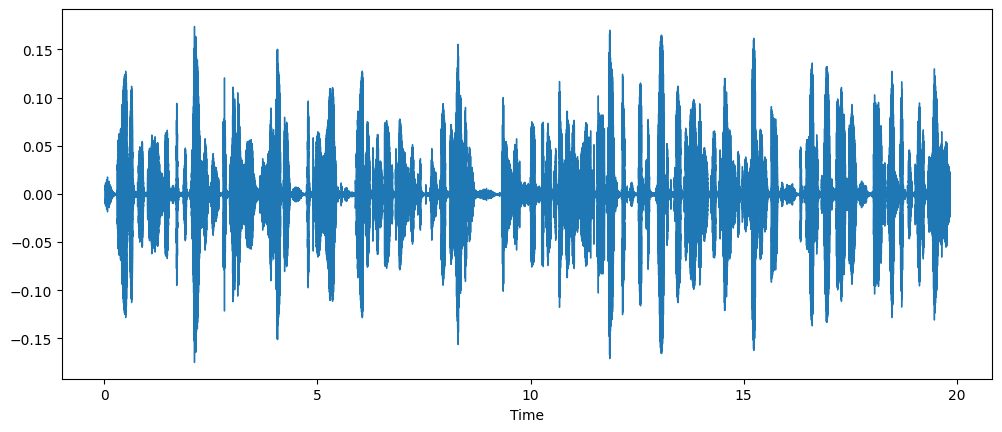

In [4]:
#4.绘制这个样本的波形图。
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = voxpopuli_3["audio"]["array"]
sampling_rate = voxpopuli_3["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)


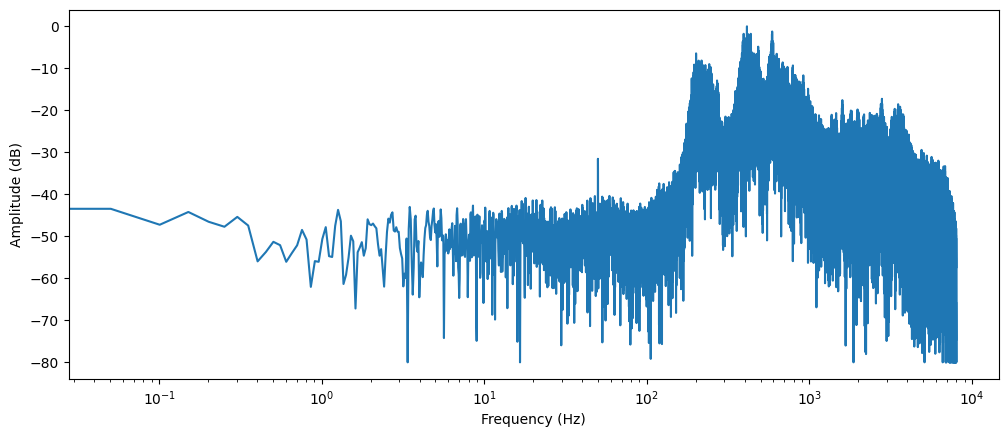

In [5]:
#4.绘制这个样本的频谱图。
import numpy as np

dft_input = array

# 计算 DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# 计算频谱的幅值，转换为分贝标度
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# 计算每个DFT分量对应的频率值
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

In [20]:
#5.前往 🤗 Hub，探索预训练模型并找到一个可以用于你之前选择的语言的自动语音识别的模型。使用你找到的模型实例化一个对应的 pipeline，并转录这个样本。
from datasets import load_dataset
voxpopuli_croatian = load_dataset("hanamizuki-ai/genshin-voice-v3.5-mandarin", streaming=True)
voxpopuli_head = voxpopuli_croatian["train"].take(5)
#voxpopuli_head = voxpopuli_head.cast_column("audio", Audio(sampling_rate=16000))
voxpopuli_1=list(voxpopuli_head)[4]
voxpopuli_1


Resolving data files:   0%|          | 0/67 [00:00<?, ?it/s]

{'audio': {'path': '0003500447cf8be7.wav',
  'array': array([ 6.10351562e-05,  0.00000000e+00, -9.15527344e-05, ...,
         -3.05175781e-05,  1.22070312e-04, -1.52587891e-04]),
  'sampling_rate': 48000},
 'language': 'CHS',
 'npcName': None,
 'text': None,
 'type': None}

In [14]:
###试图将voxpopuli_1转换为hugging face dataset object，失败
###主要是希望将'sampling_rate': 48000下采样为16000
#from datasets import Dataset
#import pandas as pd
#voxpopuli_data = Dataset.from_dict(voxpopuli_1)
#voxpopuli_data
#voxpopuli_data=Dataset.from_pandas(pd.DataFrame(data=voxpopuli_1))

ArrowInvalid: ('cannot mix list and non-list, non-null values', 'Conversion failed for column audio with type object')

In [2]:
from transformers import pipeline
asr = pipeline("automatic-speech-recognition", model="wbbbbb/wav2vec2-large-chinese-zh-cn")

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


In [4]:
from transformers import AutoFeatureExtractor

model_id = "wbbbbb/wav2vec2-large-chinese-zh-cn"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)

In [6]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [7]:
###下采样失败
from datasets import Audio

voxpopuli_1 = voxpopuli_1.cast_column("audio", Audio(sampling_rate=sampling_rate))

AttributeError: 'dict' object has no attribute 'cast_column'

In [9]:
#Input 'sampling_rate' 48000
#Model sampling_rate' 16000
#现在还不知道如何对voxpopuli_1进行下采样
asr(voxpopuli_1["audio"]["array"])

{'text': '传的沉兵可杀属传的大一的'}

In [10]:
from IPython.display import Audio
Audio(voxpopuli_1["audio"]["array"], rate=voxpopuli_1["audio"]["sampling_rate"])